# Проект: Анализ бизнес-показателей. Введение

Я — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Моя задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Мне предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Описание данных:
<br>В моем распоряжении три датасета. 
- Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
- orders_info_short.csv — информацию о заказах, 
- costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

План анализа:
- Выполнить предобработку данных,
- Задать фукции для расчёта и анализа LTV, ROI, удержания и конверсии,
- Провести исследовательский анализ данных,
- Оценить маркетинг,
- Оценить окупаемость рекламы,
- Выделить причины неэффективности привлечения пользователей,
- Сформулировать рекомендации для отдела маркетинга.

### Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta 
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math
import time
from datetime import datetime

In [2]:
# загружаем данные
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'), 
    pd.read_csv('/datasets/orders_info.csv'), 
    pd.read_csv('/datasets/costs_info.csv')  
)


In [3]:
# приводим названия столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [4]:
# приводим названия столбцов visits_data к "змеиному" регистру
visits = visits.rename(columns=
                             {'user id': 'user_id', 
                              'session start': 'session_start', 
                               'user id': 'user_id', 
                               'session end': 'session_end'})
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


In [5]:
# приводим названия столбцов orders_data к "змеиному" регистру
orders = orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'})
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
# заменим типы данных
visits['session_start'] = pd.to_datetime(visits['session_start'], format="%d.%m.%Y %H:%M")
visits['session_end'] = pd.to_datetime(visits['session_end'], format="%d.%m.%Y %H:%M")
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format="%Y-%m-%d %H:%M:%S")
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [7]:
# проверим типы данных
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [10]:
# изучим пропуски
pd.DataFrame(round(visits.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
region,0.000000
device,0.000000
channel,0.000000
session_start,0.000000
session_end,0.000000


In [11]:
pd.DataFrame(round(orders.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
revenue,0.000000


In [12]:
pd.DataFrame(round(costs.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
dt,0.000000
channel,0.000000
costs,0.000000


In [13]:
# проверим дубликаты
visits.duplicated().sum()

0

In [14]:
orders.duplicated().sum()

0

In [15]:
costs.duplicated().sum()

0

**Короткий вывод о проблемах с данными:**
<br> Изучила общую информацию о датафреймах. Выполнила предобработку данных:
 - Привела названия столбцов к "хорошему тону". 
 - Для удобства работы заменила типы данных в стобцах с датой. 
 - Пропусков, дубликатов в данных нет. <br> Вперед!

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [16]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

In [17]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

In [18]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [19]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Вывод:** <br>  Заданы функции для расчёта и анализа LTV, ROI, удержания и конверсии.

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

*3.1 Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.*

In [25]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

*Получим профили пользователей:*

In [26]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head()) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


*Определим минимальную и максимальную даты привлечения пользователей.*

In [27]:
min_analysis_date = profiles['dt'].min()
min_analysis_date

Timestamp('2019-05-01 00:00:00')

In [28]:
observation_date = profiles['dt'].max()
observation_date

Timestamp('2019-10-27 00:00:00')

**Вывод:** На данном этпа составлены профили пользователей. Определены минимальная дата привлечения пользователей - 1 мая 2019 г., и максимальная - 27 октября 2019 г.

*3.2 Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.*

In [29]:
region_payer_segment = pd.DataFrame()
region_payer_segment['users_count']=profiles.groupby('region')['user_id'].count()
region_payer_segment['users_payer_count']=profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_segment['share'] = (region_payer_segment['users_payer_count'] / region_payer_segment['users_count'])*100
region_payer_segment.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})


,users_count,users_payer_count,share
region,,,
United States,100002,6902,6.9%
Germany,14981,616,4.1%
UK,17575,700,4.0%
France,17450,663,3.8%


**Вывод:** Нашим приложением Procrastinate Pro+ пользуются жители стран США, Великобритании, Франции и Германии. Больше всего платящих пользователей находится в США (7%), в остальных странах - Великобритании, Франции, Германии доли платящих пользователей не сильно отличаются и составляют около 4%.

*3.3 Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.*

In [30]:
device_payer_segment = pd.DataFrame()
device_payer_segment['users_count']=profiles.groupby('device')['user_id'].count()
device_payer_segment['users_payer_count']=profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_segment['share'] = (device_payer_segment['users_payer_count'] / device_payer_segment['users_count'])*100
device_payer_segment.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_count,users_payer_count,share
device,,,
Mac,30042,1912,6.4%
iPhone,54479,3382,6.2%
Android,35032,2050,5.9%
PC,30455,1537,5.0%


**Вывод:** Наиболее популярным устройством среди пользователей нашего приложения является iPhone (54479 пользователей, из них 6.2% платящих). На втором месте - Android (35032, из них 5.9% платящих)). Замыкают наш рейтинг пользователи Mac (30042, из них 6.4% платящих)) и PC (30455, из них 5.0% платящих)). Доли платящих пользователей Mac и iPhone выше, чем Android и PC.

*3.4 Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.*

In [31]:
channel_payer_segment = pd.DataFrame()
channel_payer_segment['users_count']=profiles.groupby('channel')['user_id'].count()
channel_payer_segment['users_payer_count']=profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_payer_segment['share'] = (channel_payer_segment['users_payer_count'] / channel_payer_segment['users_count'])*100
channel_payer_segment.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_count,users_payer_count,share
channel,,,
FaceBoom,29144,3557,12.2%
AdNonSense,3880,440,11.3%
lambdaMediaAds,2149,225,10.5%
TipTop,19561,1878,9.6%
RocketSuperAds,4448,352,7.9%
WahooNetBanner,8553,453,5.3%
YRabbit,4312,165,3.8%
MediaTornado,4364,156,3.6%
LeapBob,8553,262,3.1%


**Вывод:** Больше всего платящих пользователей пришло из канала "FaceBoom" (12.2%), "AdNonSense" (11.3%), "lambdaMediaAds" (10.5%), немного отстают пользователи из "TipTop" (9.6%). Доля остальных источников варьируется от 2.7% до 8%. 2.1% платящих пользователей пришли сами, без рекламы.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

*4.1 Посчитаем общую сумму расходов на маркетинг.*

In [32]:
costs['costs'].sum().round()

105497.0

**Вывод:** Всего на маркетинг потрачено $105497.

*4.2 Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.*

In [33]:
costs_channel = pd.DataFrame()
costs_channel['costs']=costs.groupby('channel')['costs'].sum()
costs_channel['share'] = (costs_channel['costs'] / costs['costs'].sum()) * 100
costs_channel.sort_values(by='costs', ascending=False).style.format({'share': '{:.1f}%'})

,costs,share
channel,,
TipTop,54751.300000,51.9%
FaceBoom,32445.600000,30.8%
WahooNetBanner,5151.000000,4.9%
AdNonSense,3911.250000,3.7%
OppleCreativeMedia,2151.250000,2.0%
RocketSuperAds,1833.000000,1.7%
LeapBob,1797.600000,1.7%
lambdaMediaAds,1557.600000,1.5%
MediaTornado,954.480000,0.9%


**Вывод:** Больше всего денег потратили на источник "TipTop" - 54751.3 долларов (52%). На втором месте - "FaceBoom" 32445.6 долларов (31%). На остальные источники тратили в среднем от 1 до 5% от общей суммы.

*4.3 Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.*

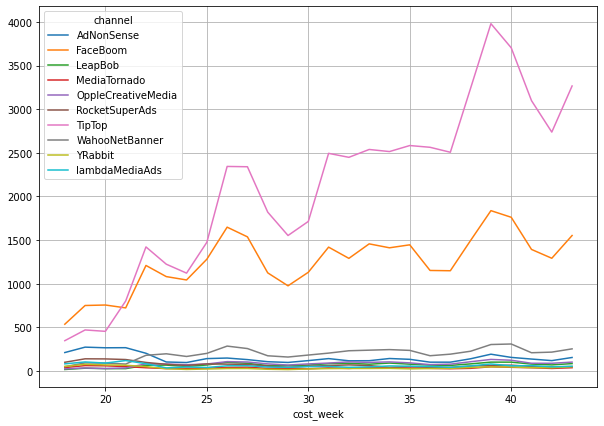

In [34]:
#  визуализация динамики изменения расходов во времени неделям по каждому источнику
costs['cost_week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

costs.pivot_table(
    index='cost_week',  
    columns='channel',
    values='costs', 
    aggfunc='sum'  
).plot(figsize=(10, 7), grid=True)

plt.show()

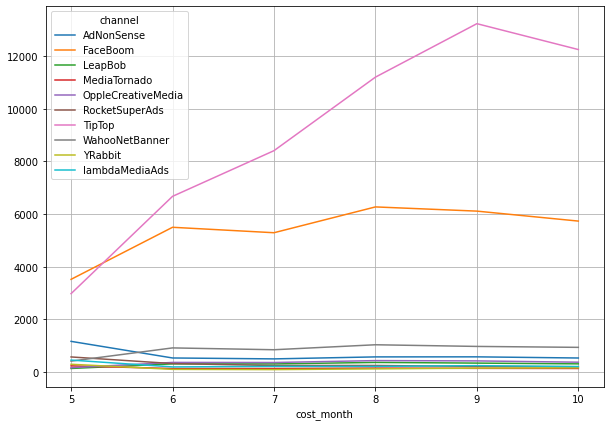

In [35]:
#  визуализация динамики изменения расходов во времени месяцам по каждому источнику
costs['cost_month'] = pd.to_datetime(costs['dt']).dt.month

costs.pivot_table(
    index='cost_month',  
    columns='channel',
    values='costs', 
    aggfunc='sum'  
).plot(figsize=(10, 7), grid=True)

plt.show()

**Вывод:** По графикам также видим, что больше всего денег ушло на рекламу в "TipTop", на втором месте - "FaceBoom". Затраты на "TipTop" в целом увеличиваются, в остальных источниках такой динамики не наблюдаем. 

*4.4 Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.*

In [36]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [37]:
# сформируем таблицу
cac_channel = pd.DataFrame()
profiles = profiles.query('channel != "organic"')
cac_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


**Вывод:** Стоимость привлечения «органических» пользователей во всех когортах равна нулю, потому что они пришли в «Procrastinate Pro+» самостоятельно, а не благодаря рекламе. Привлечение одного пользователя из рекламной сети «TipTop» - наиболее затратное ($2.8), в отличие от LeapBob, где привлечение одного пользователя обошлось компании в среднем в 21 цент.

Найдем средний CAC на одного пользователя для всего проекта, так увидим на сколько выше среднего САС у популярных каналов:

In [38]:
profiles['acquisition_cost'].mean()

1.1274813239427588

Средний CAC на одного пользователя для всего проекта составляет 1.13. Выше только у "TipTop".

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

*5.1 Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.*

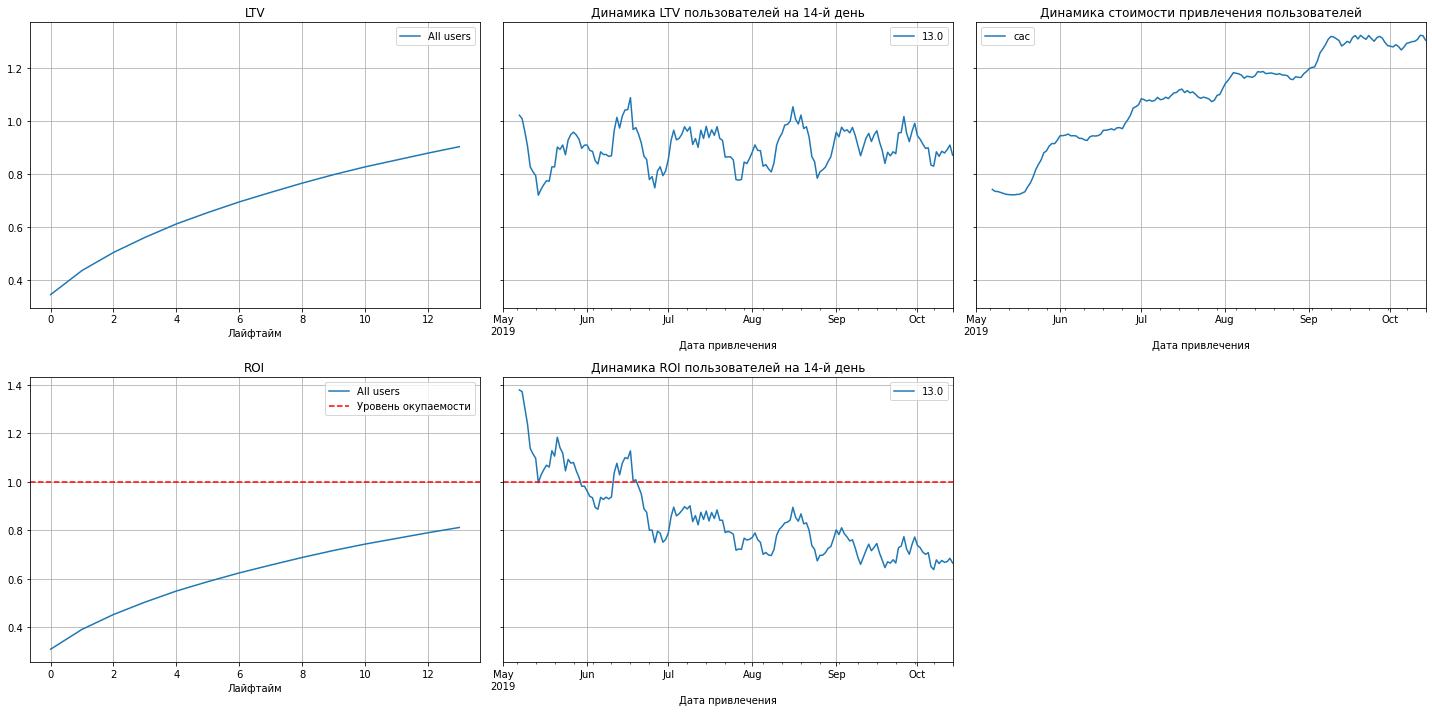

In [39]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Реклама не окупается. К концу второй недели ROI около 80%.
- CAC нестабилен, увеличивается с течением времени.
- На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
- Динамика ROI отрицательная. С июля мы ушли в минус, клиенты «не окупились».

*5.2 Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.*

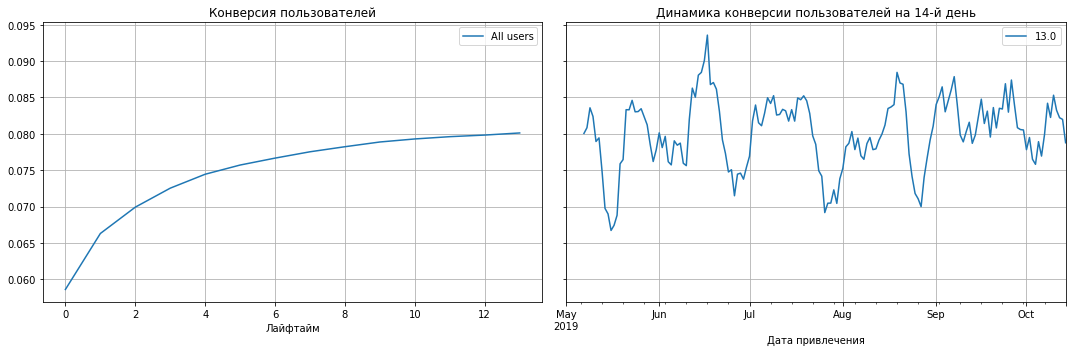

In [40]:
#графики конверсии

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, 
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

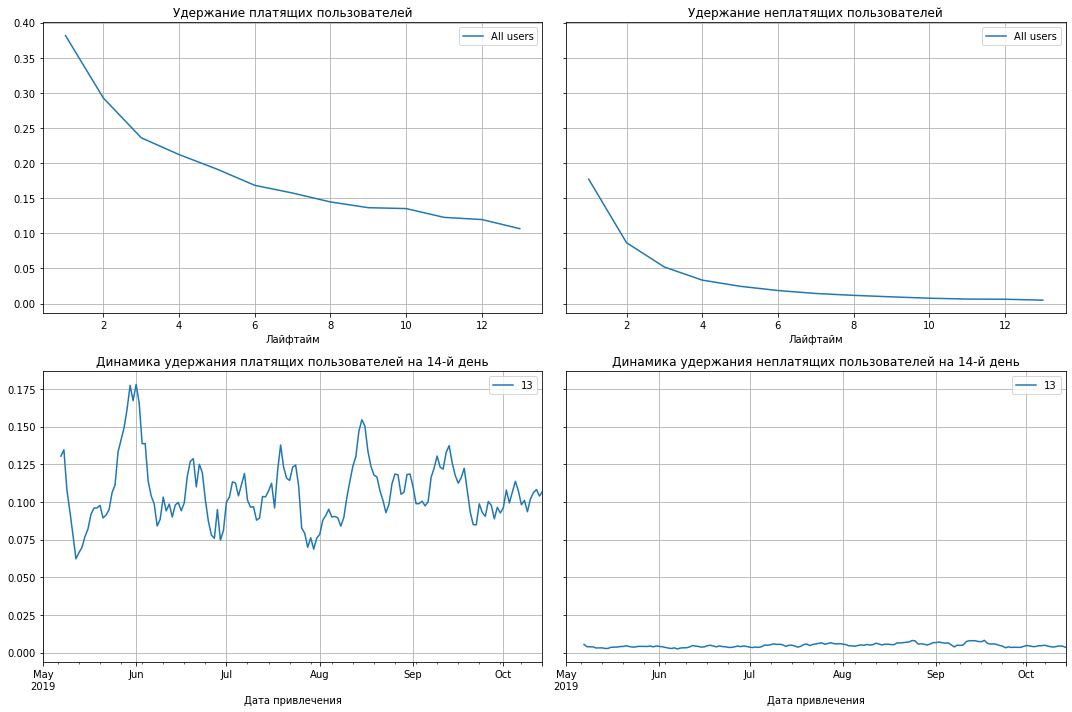

In [41]:
#графики удержания

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)
plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод:** Судя по графикам, пользователи конвертируются хорошо, причём постоянно. Удержание платящих пользователей лучше, чем неплатящих. Последним нечего терять, все логично.

*5.3 Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

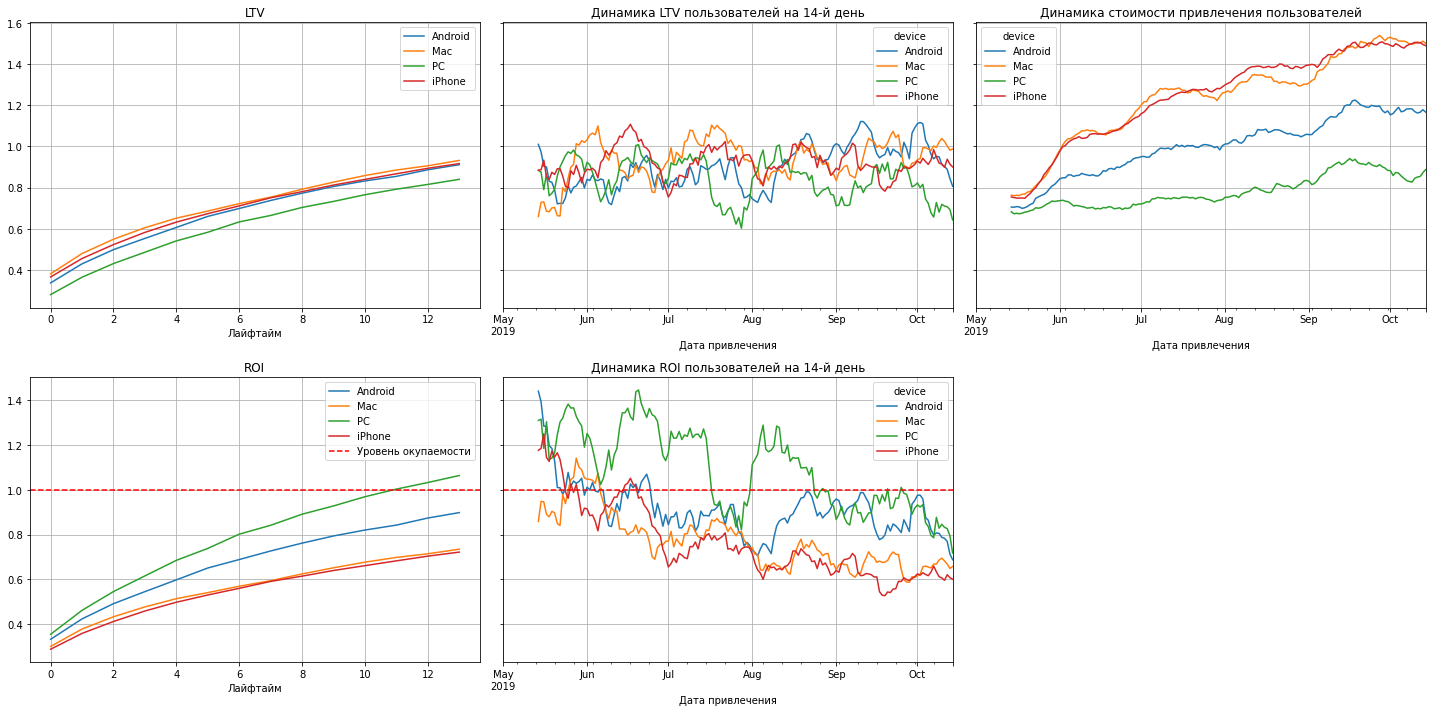

In [42]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

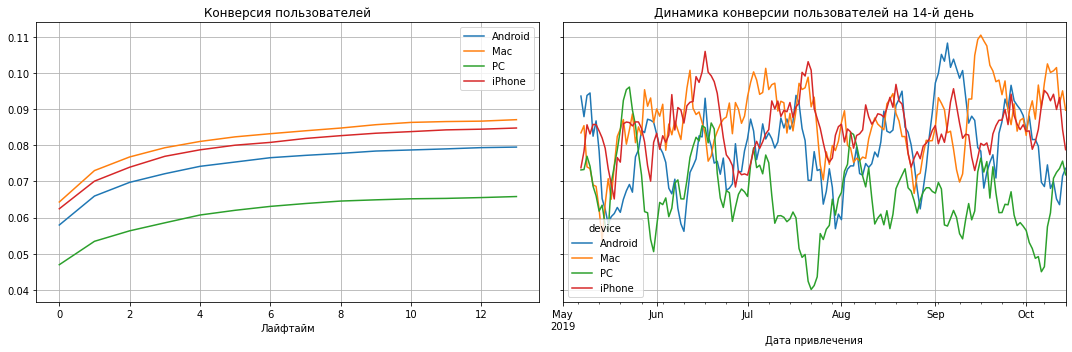

In [43]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

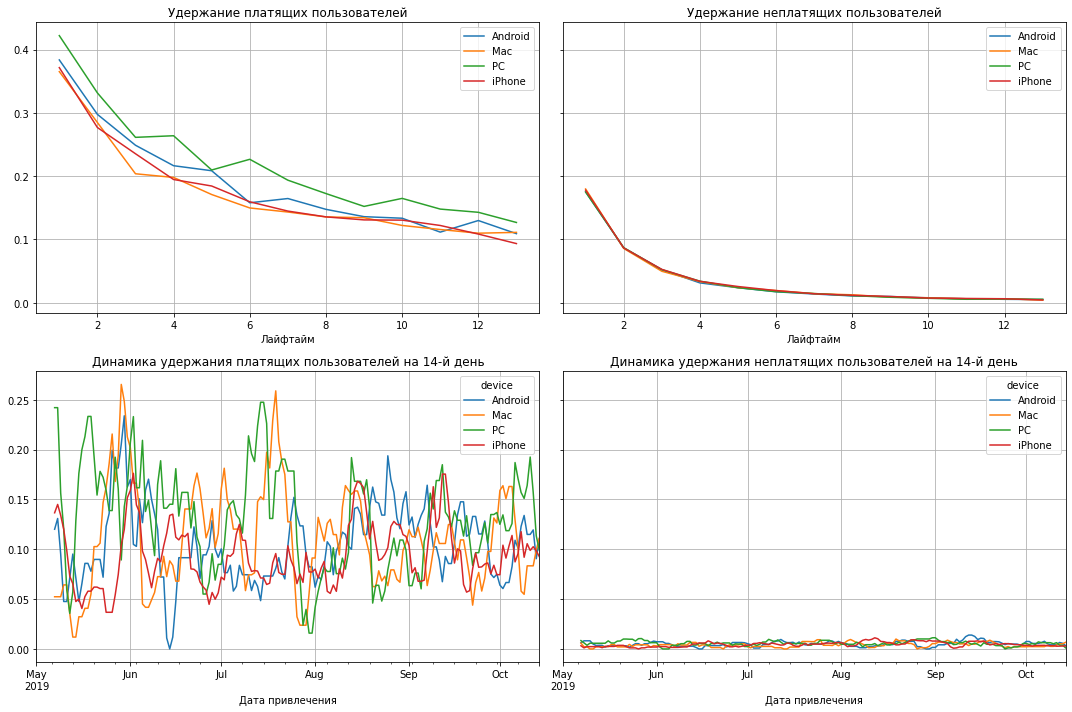

In [44]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод:** 
<br> Лучше всего конвертируются владельцы Iphone и Mac, при этом их удержание ниже остальных. 
Самая низкая стоимость привлечения у PC, дороже - Android, самые дорогие - Iphone и Mac.
ROI падает у всех устройств. Инвестиции в Iphone, Mac и Android не окупились, в то время как стоимость их привлечения самая высокая + продолжает расти. 
LTV пользователей всё так же подвержен сезонности, но стабилен. Удержание платящих пользователей лучше, чем неплатящих.

Итого:
- сумма денег, которую один клиент в среднем приносит компании с каждого устройства растет.
- сумма денег, в которую компании обходится каждый новый клиент для каждого устройства растет.
- в Iphone, Mac и Android  инвестируем больше остальных, но они уходят в минус нашему бюджету.

*5.4 Проанализируем окупаемость рекламы с разбивкой по странам.*

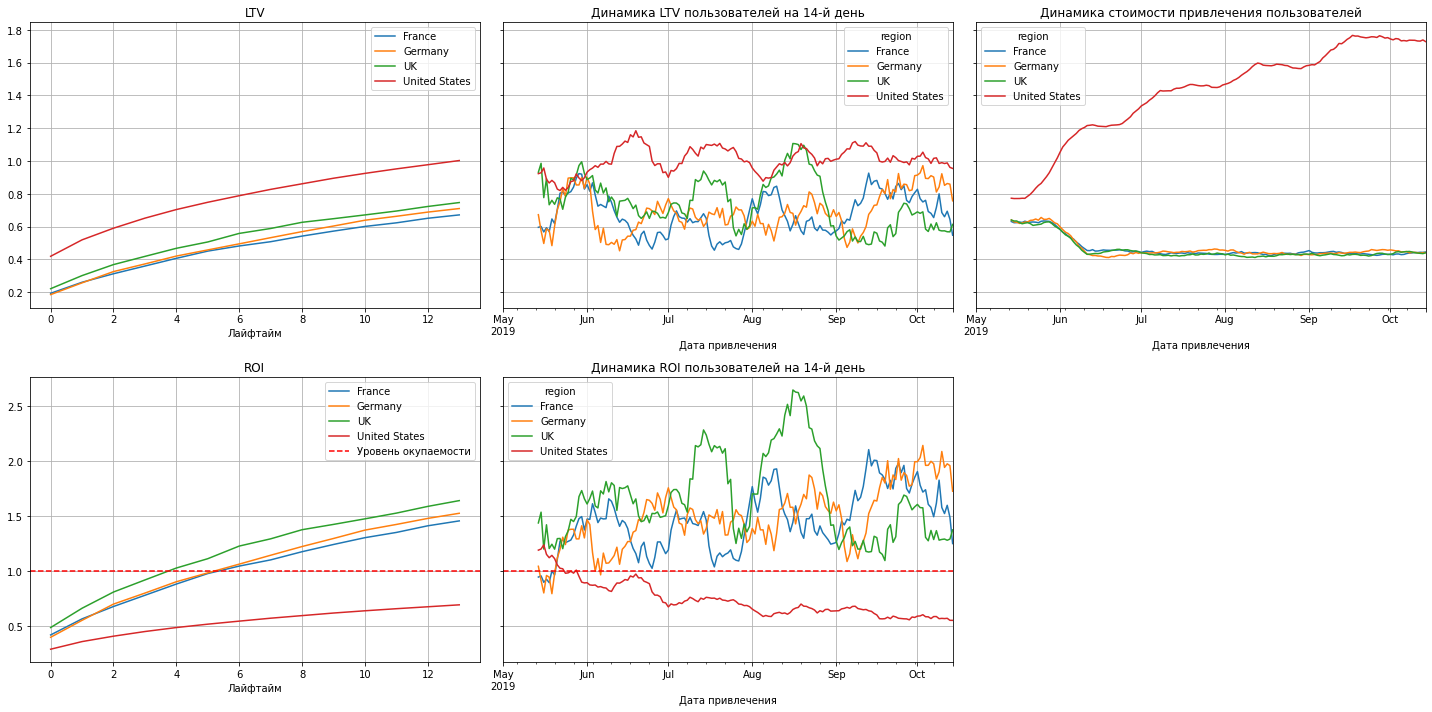

In [45]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

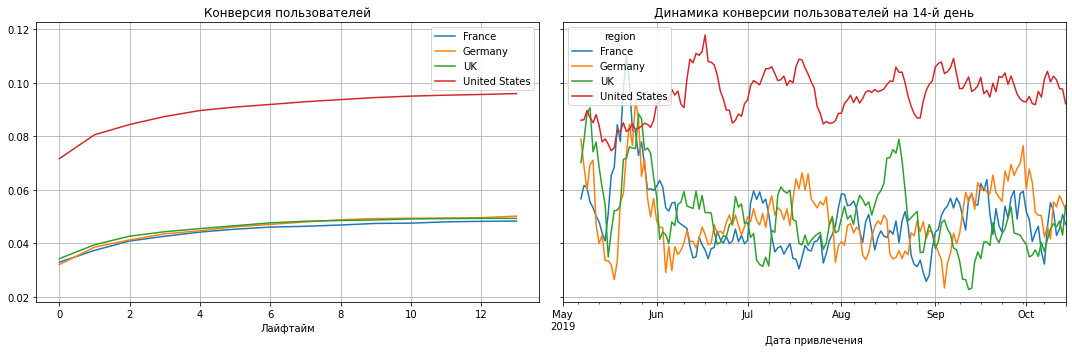

In [46]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

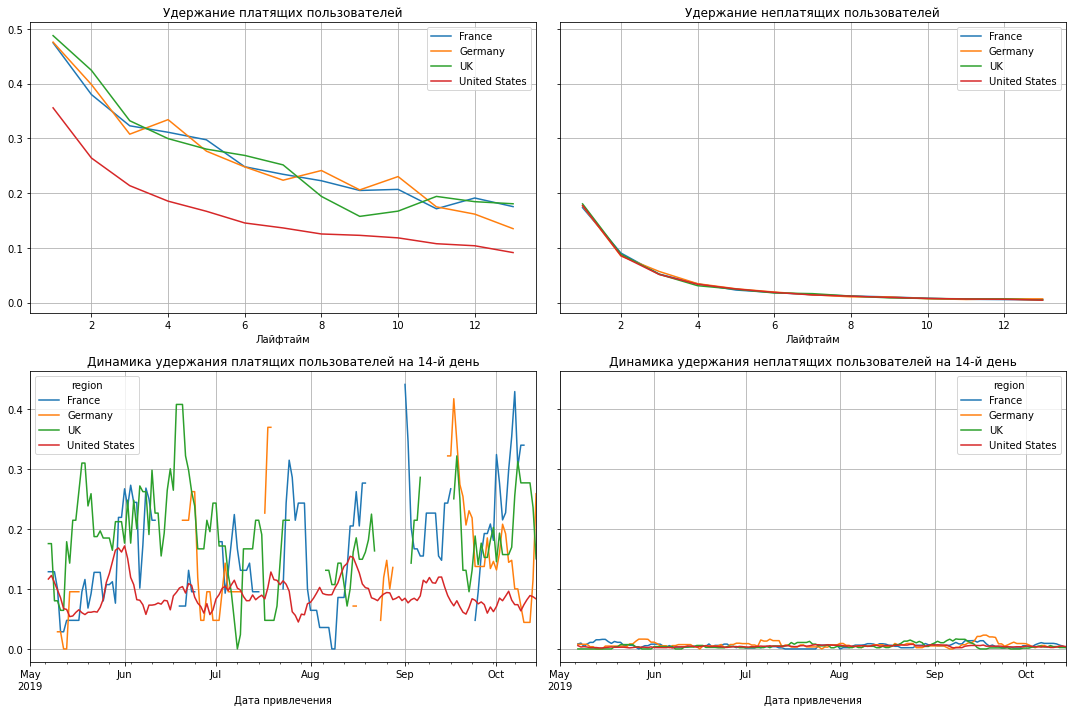

In [47]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод:**
- Лучше всего конвертируются пользователи из США. При этом по графику видим, что их удержание ниже остальных. 
- Больше всего денег мы инвестируем в США, при этом они единственные, кто не окупился (с июня ROI стал ниже уровня окупаемости и продолжал падать).
- LTV всё так же подвержен сезонности, но стабилен.

Изучим рекламу США отдельно.

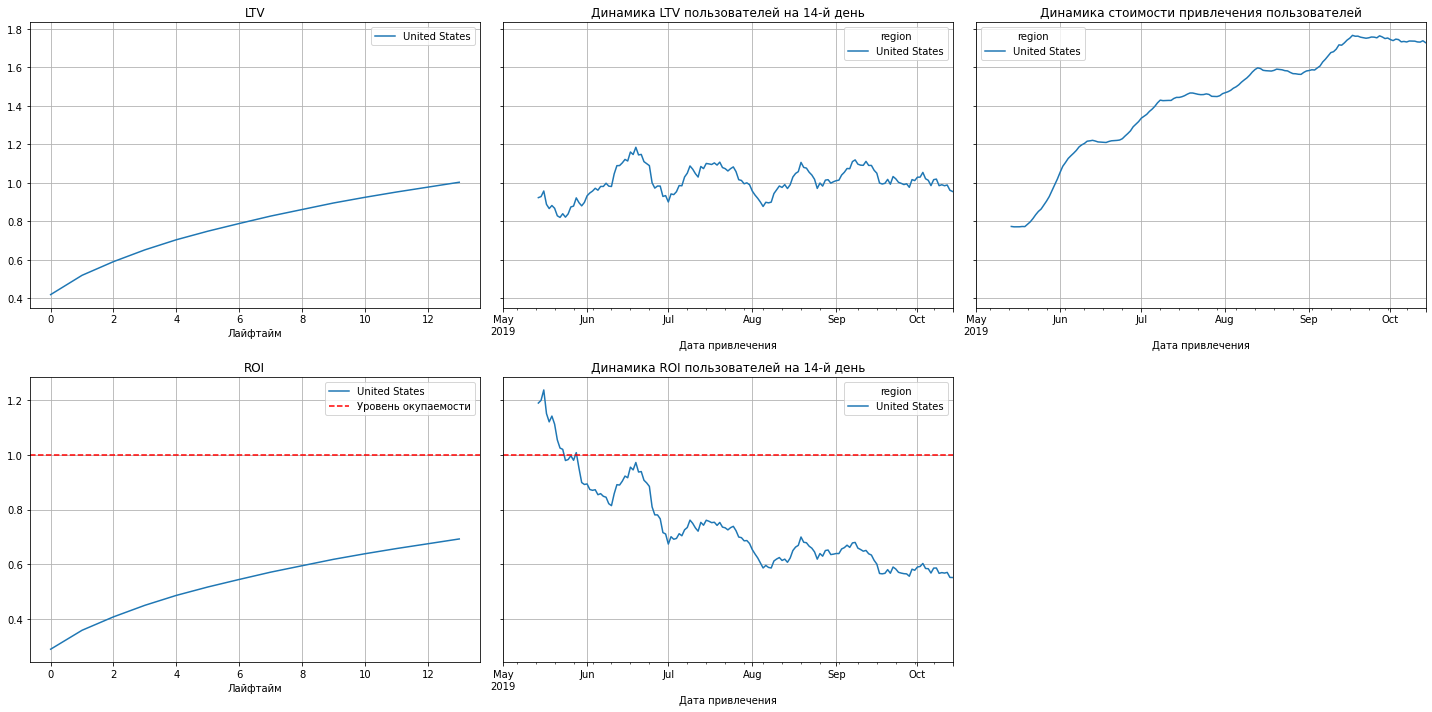

In [48]:
region_usa = ['United States']
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in @region_usa'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

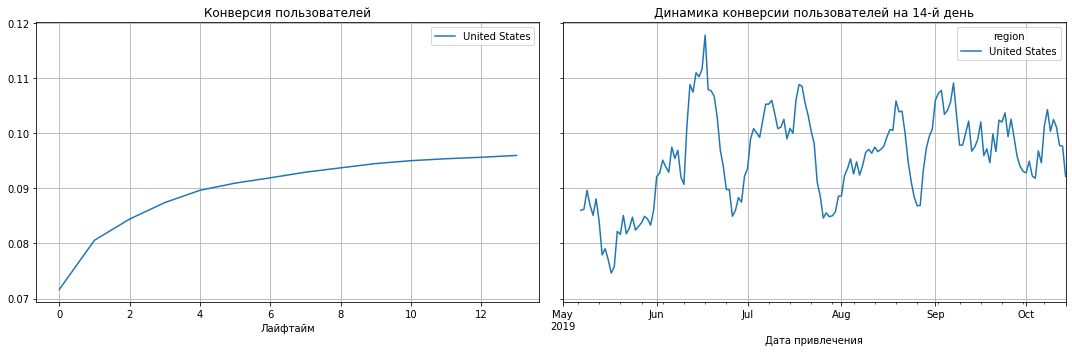

In [49]:
# смотрим конверсию США

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('region in @region_usa'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

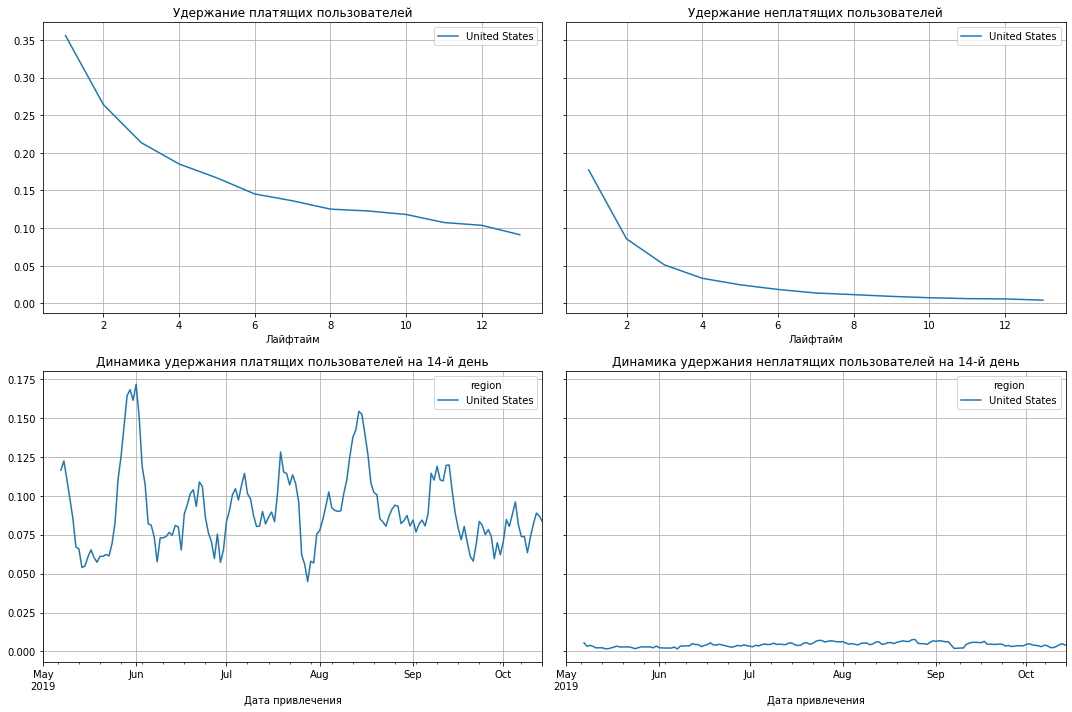

In [50]:
# смотрим удержание США

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('region in @region_usa'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод:** В США к концу второй недели реклама не окупилась, ROI составлял около 70%. Начиная с июня ROI стремительно падал.

*5.5 Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.*

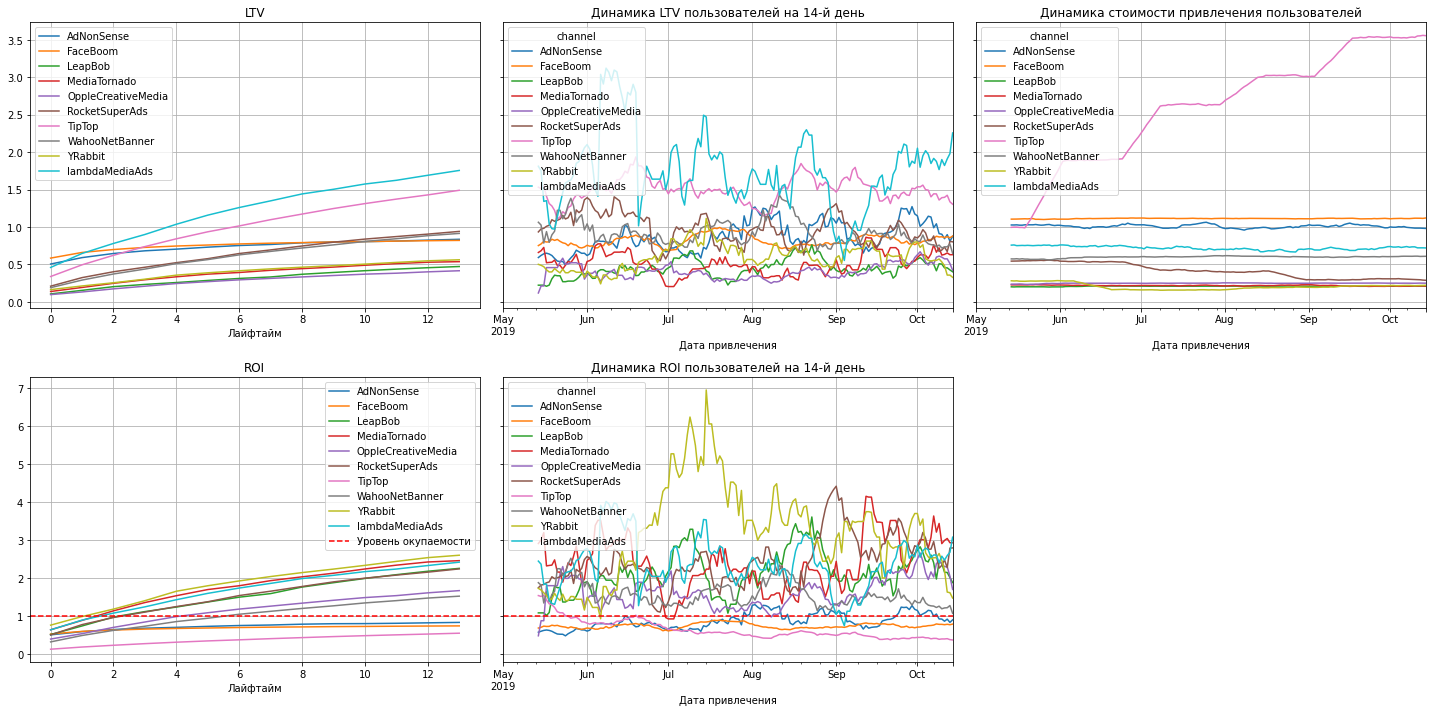

In [51]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

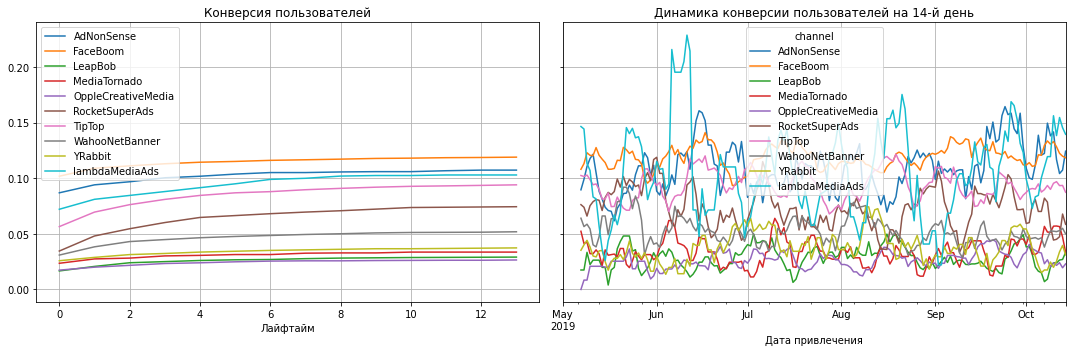

In [52]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

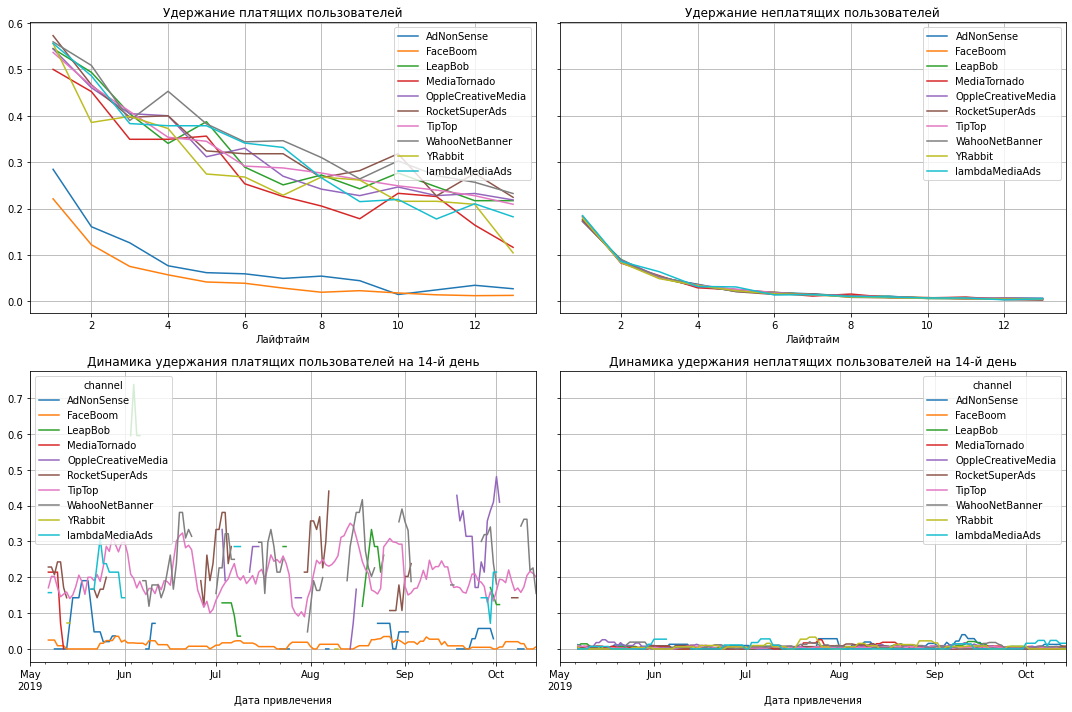

In [53]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

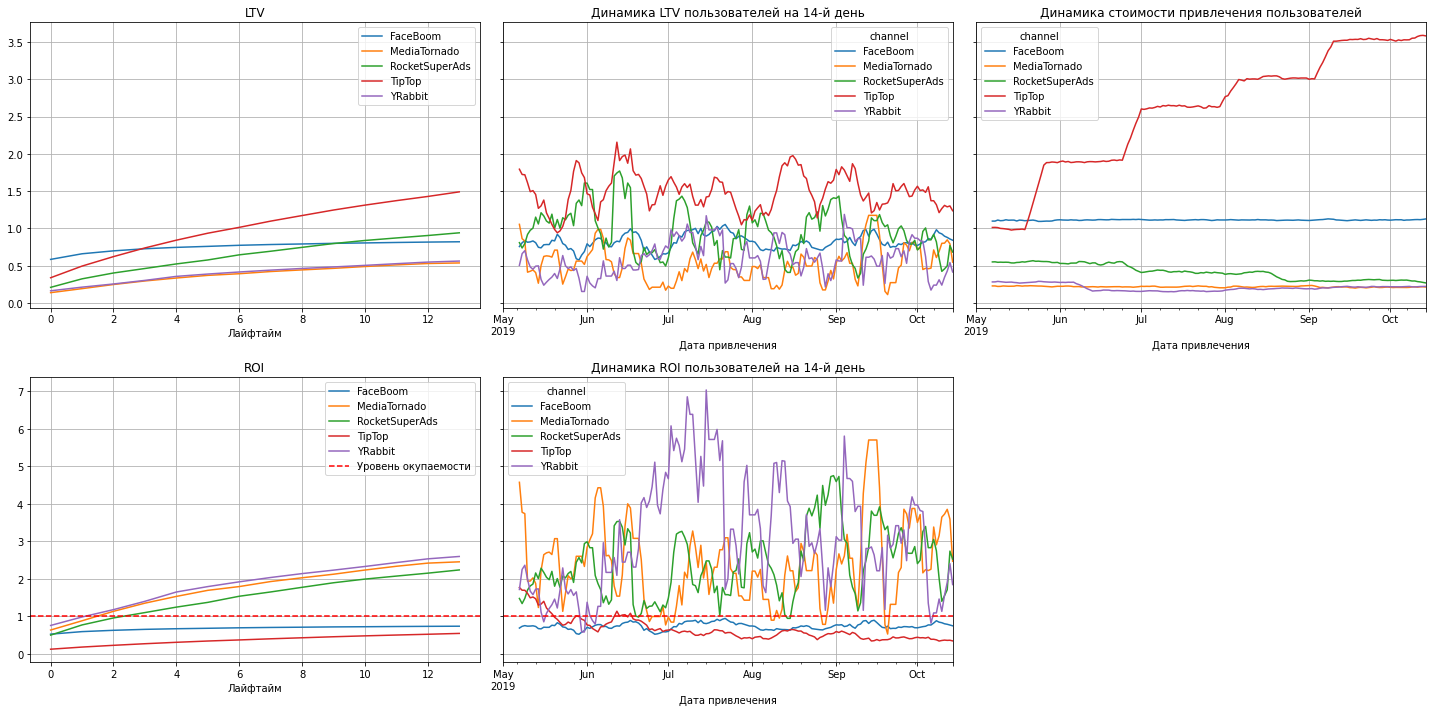

In [54]:
 # посмотрим отдельно окупаемость каналов США
region_usa = ['United States']
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in @region_usa'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

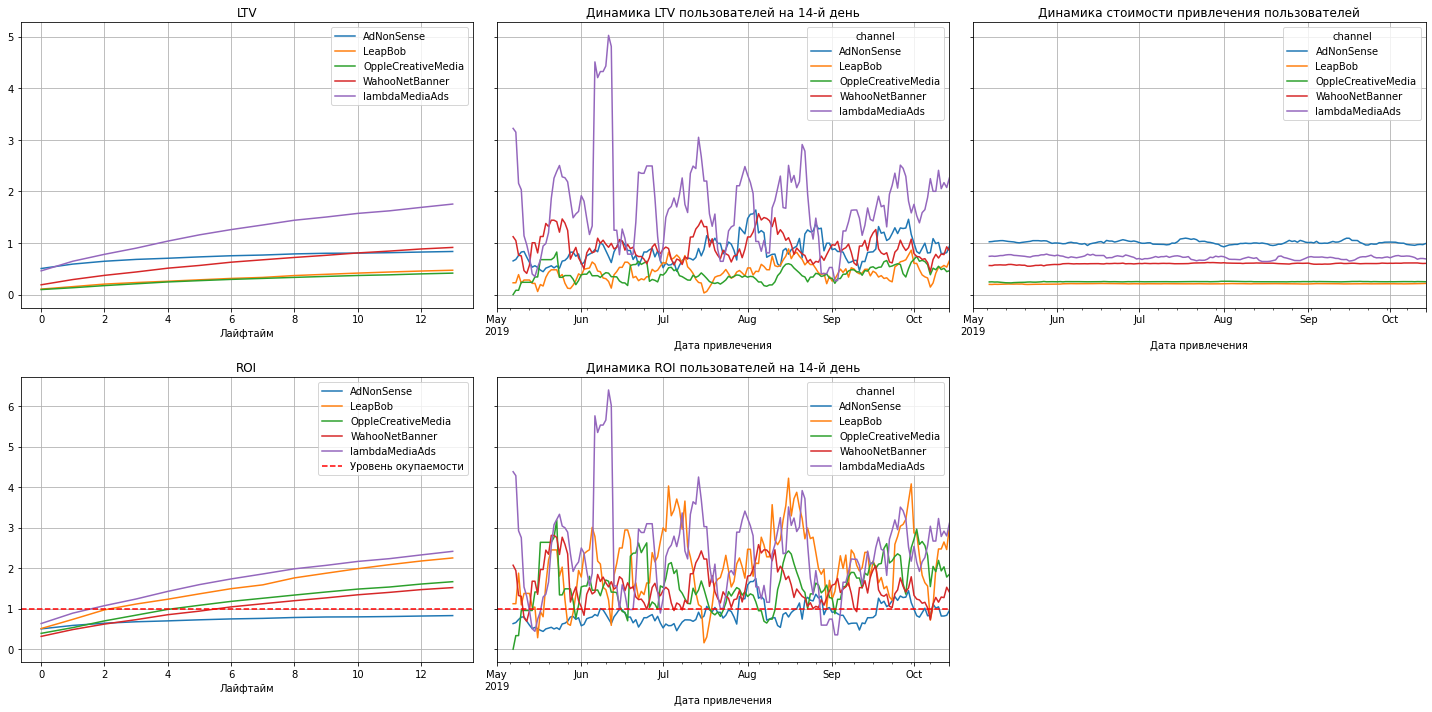

In [55]:
 # посмотрим отдельно окупаемость каналов Европы
region_eu = ['France', 'Germany', 'UK']
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in @region_eu'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

**Вывод:** 
- Лучше других конвертируются "FaceBoom" и "Adnonsense", при этом их удержание сильно ниже остальных.
- Больше всего денег мы вкладываем в "Tip Top", при этом он  аутсайдер в нашем топе по уровню окупаемости. Также не окупаются "FaceBoom", "Adnonsense".
- "YRabbit" окупилась лучше, в июле ROI на 14-й день был гораздо выше остальных.
- В США окупаются YRabbit, MediaTornado, RocketSuperAds. При этом стоимость их привлечения сильно ниже остальных. 
- В Европе не окупился только "Adnonsense", при этом в них мы инвестируем больше остальных. Лидирует по окупаемости "LambdaMediaAds".

Мы имеем следующую картину:

В целом реклама не окупается к концу второй недели, ROI составляет около 80%.  Занижают показатели пользователи Iphone и Mac, пользователи из  США, рекламные источники "Tip Top", "FaceBoom", "Adnonsense".

Причинами могут быть следующие факторы:
- Неудобное приложение на IOS, технические ошибки при оплате.
- Скорее всего, большинство пользвателей Iphone и Mac находятся в США, отсюда и низкая окупаемость.
- Отдел маркетинга переоценил рекламные источники "Tip Top", "FaceBoom", "Adnonsense". Лучше присмотреться к "YRabbit", "MediaTornado", "lambdaMediaAds " - лидерам по уровню окупаемости.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

**Вывод**

Несмотря на огромные вложения в рекламу, последние несколько месяцев Procrastinate Pro+ терпит убытки. Я попыталась разобраться в причинах и помочь компании выйти в плюс.
 
После подготовки данных к анализу задала функции для расчёта и анализа LTV, ROI, удержания и конверсии.
 
Провела исследовательский анализ данных: составила профили пользователей, изучила общую информацию: где живут люди, которые нам платят, с каких устройств они это делают, а также рекламные каналы, благодаря которым они к нам пришли. Вот главное из моего анализа:
- Нашим приложением Procrastinate Pro+ пользуются жители стран США, Великобритании, Франции и Германии. Больше всего платящих пользователей находится в США (7%), в остальных странах - Великобритании, Франции, Германии доли платящих пользователей не сильно отличаются и составляют около 4%.
- Наиболее популярным устройством среди пользователей нашего приложения является iPhone (54479 пользователей, из них 6.2% платящих). На втором месте - Android (35032, из них 5.9% платящих)). Замыкают наш рейтинг пользователи Mac (30042, из них 6.4% платящих)) и PC (30455, из них 5.0% платящих)). Доли платящих пользователей Mac и iPhone выше, чем Android и PC. 
- Больше всего платящих пользователей пришло из канала "FaceBoom" (12.2%), "AdNonSense" (11.3%), "lambdaMediaAds" (10.5%), немного отстают пользователи из "TipTop" (9.6%). Доля остальных источников варьируется от 2.7% до 8%. 2.1% платящих пользователей пришли сами, без рекламы.

Теперь перейдем к маркетингу:
- Всего на маркетинг потрачено 105497 долларов. 
- Больше всего денег потратили на источник "TipTop" - 54751.3 долларов (52%). На втором месте - "FaceBoom" 32445.6 долларов (31%). На остальные источники тратили в среднем от 1 до 5% от общей суммы. Затраты на "TipTop" в целом увеличиваются, в остальных источниках такой динамики не наблюдаем.
- Привлечение одного пользователя из рекламной сети «TipTop» - наиболее затратное (2.8 долларов), в отличие от "LeapBob", где привлечение одного пользователя обошлось компании в среднем в 21 цент.

И, наконец, перейдем к главному - оценим окупаемость рекламы:
- Реклама не окупается. К концу второй недели ROI около 80%. Занижают показатели пользователи Iphone и Mac, пользователи из  США (ROI к концу 2-й недели около 70%), рекламные источники "Tip Top", "FaceBoom", "Adnonsense". Вероятнее всего, причину убытков компании стоит искать здесь.

Рекомендации для отдела маркетинга:

- В рекламе США есть проблемы: в "TipTop" и "FaceBoom" мы инвестируем больше всего денег, при этом трафик не окупается. Особенно "TipTop" - они самые убыточные, стоит сократить в них инвестиции. Более перспективны - "YRabbit", "MediaTornado", "RocketSuperAds", эти каналы окупились, при этом стоимость их привлечения была сильно ниже остальных. 


- В Европе стоит сократить расходы на "Adnonsense" - в них мы инвестируем больше всех, но инвестиции не окупились. Лидируют по окупаемости "LambdaMediaAds", "LeapBob", "OppleCreativeMedia".


- Платящие PC пользователи удерживаются лучше остальных, при этом конверсия самая низкая. Стоит обратить внимание на качество рекламы.


- Инвестиции в Iphone и Mac не окупились, в то время как стоимость их привлечения самая высокая + продолжает расти. Здесь есть проблема, ее нужно устранить (может, это неудобное приложение на IOS или технические ошибки при оплате?).


- У нас мало пользователей в Великобритании, Франции, Германии. В них у нас гораздо меньше пользователей, чем в США, при этом процент платящих высок. Есть потенциал развития в этих странах, стоит вложиться в рекламу, чтобы привлечь больше клиентов.


- Каналы FaceBoom, AdNonSense - проблемы с удержанием. Возможно, это связано с тем, что мы привлекаем из них нецелевую аудиторию.